# Credit Card Fraud Detection Model
---------------------
 - 결제, 이체 등의 과정에서 발생하는 사기를 찾아내는 "분류" 모델입니다.
 - 해당 데이터셋에는 각 데이터별로 "사기"의 여부를 알려주는 지표가 있고, 이를 Target으로 설정하여 프로젝트를 진행합니다.
 - 사기인 경우의 수가 적기 때문에, 이 부분에서 예측모델을 만들 때 문제가 생길 것으로 예상됩니다.

# 데이터 선정이유

- 현실을 잘 반영한 데이터입니다. 아래에서 살펴볼 수 있겠지만 실생활에서 사기는 잘 일어나지 않기 때문에 적은 경우를 가지고 예측 모델을 만들 수 있는 데이터라고 생각합니다.(클래스 불균형 문제)

# 왜 필요할까?

-  최근 많은 사람들이 모바일뱅킹, 인터넷뱅킹을 이용한다. 이에 따라서 모바일, 인터넷 환경에서 일어나는 결제, 이체 과정에서 사기는 늘어날 것으로 예상됩니다. 
- 이에 따라 결제, 이체 과정에서 사기를 탐지하는 것은 좀 더 "안정적인 뱅킹 서비스"를 제공하는 것에 도움이 된다고 생각합니다.

## Data Load

In [91]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
from category_encoders import OrdinalEncoder, TargetEncoder, QuantileEncoder, OneHotEncoder
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, f1_score, roc_auc_score, roc_curve, confusion_matrix

In [2]:
data = pd.read_csv('sec2_data.csv') 

## Data EDA

In [3]:
data.head(5)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [4]:
# 현재 데이터에는 결측치가 없습니다.
data.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [5]:
# isFlaggedFraud -> isFraud와 비슷한 성격을 가지고 있어 Data Leakage의 우려가 있어 제거하고
# 프로젝트를 진행합니다.
# nameOrig, nameDest -> 이 두 Column은 이름과 비슷한 것이여서 drop후 model을 만드려고 합니다.
data = data.drop(['isFlaggedFraud', 'nameOrig', 'nameDest'], axis = 1)

([<matplotlib.patches.Wedge at 0x228b62d15b0>,
 [Text(0.49426122663384003, 0.9827033325711335, 'PAYMENT'),
  Text(-1.0906766219942048, -0.1429143318051433, 'TRANSFER'),
  Text(0.3384112332518691, -1.046650771369777, 'CASH_OUT'),
  Text(1.0495474656709025, -0.3293176541028222, 'DEBIT'),
  Text(1.0997698357971, -0.022501294869852733, 'CASH_IN')],
 [Text(0.26959703270936725, 0.5360199995842546, '35.17'),
  Text(-0.594914521087748, -0.07795327189371452, '33.81'),
  Text(0.1845879454101104, -0.5709004207471511, '21.99'),
  Text(0.5724804358204921, -0.17962781132881211, '8.38'),
  Text(0.5998744558893272, -0.012273433565374218, '0.65')])

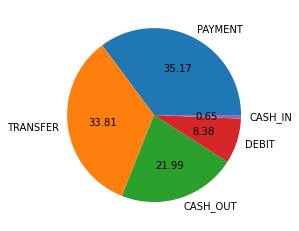

In [6]:
# Type의 분포에 대해 살펴보았습니다
plt.pie(data['type'].value_counts(normalize=True), labels = data['type'].unique(), autopct = '%.2f')

([<matplotlib.patches.Wedge at 0x22951c43f40>,
 [Text(-1.099990955625572, 0.004460666087110192, 'Not Fraud'),
  Text(1.0999909559371663, -0.004460589247970448, 'Fruad')],
 [Text(-0.5999950667048575, 0.002433090592969195, '99.87'),
  Text(0.599995066874818, -0.002433048680711153, '0.13')])

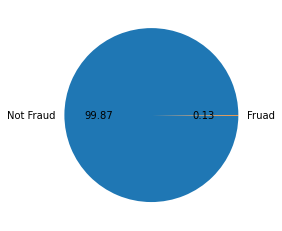

In [90]:
# Target의 분포를 살펴보면 'Not Fraud' 99.9% 'Fraud' 0.1% 로 불균형 상태이다.

plt.pie(data['isFraud'].value_counts(normalize = True), labels = ['Not Fraud', 'Fruad'], autopct='%.2f')

([<matplotlib.patches.Wedge at 0x228cf0b9f40>,
 [Text(-1.0999816304840733, 0.006357090340696732, ''),
  Text(1.0999816299842, -0.006357176834284399, '')],
 [Text(-0.5999899802640399, 0.0034675038221982173, '99.82'),
  Text(0.5999899799913818, -0.0034675510005187627, '0.18')])

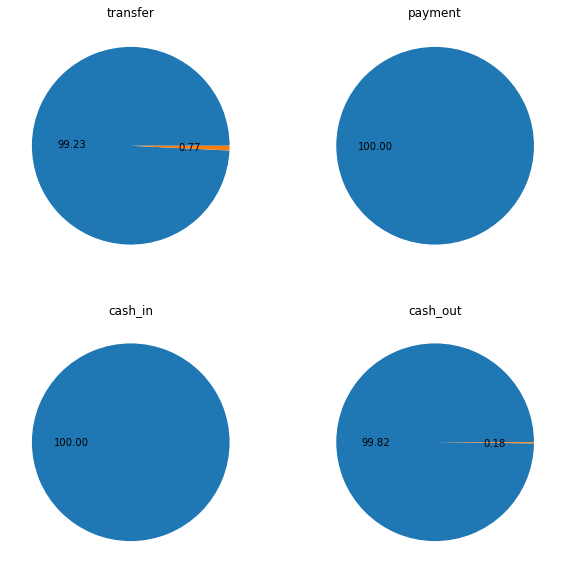

In [8]:
# type 별로 target의 분포
plt.figure(figsize=(10,10))

plt.subplot(2,2,1)
plt.title('transfer')

plt.pie(data[data['type'] == 'TRANSFER']['isFraud'].value_counts(),  autopct='%.2f')

plt.subplot(2,2,2)
plt.title('payment')
plt.pie(data[data['type'] == 'PAYMENT']['isFraud'].value_counts(), autopct='%.2f')


plt.subplot(2,2,3)
plt.title('cash_in')
plt.pie(data[data['type'] == 'CASH_IN']['isFraud'].value_counts(), autopct='%.2f')

plt.subplot(2,2,4)
plt.title('cash_out')
plt.pie(data[data['type'] == 'CASH_OUT']['isFraud'].value_counts(), autopct='%.2f')

결제 유형별로 target의 분포를 살펴보면 paymet와 cash_in 에서 사기인 경우는 없는 것으로 나타났습니다.

## Data Preprocessing

먼저 학습, 검증, 테스트에 쓰일 데이터를 나누어 줍니다.

In [9]:
# train, val, test data로 Split

X = data[data.columns[:-1]]
y = data[data.columns[-1]]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state = 42)

print(X_train.shape, X_val.shape, X_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)

(4072076, 7) (1018020, 7) (1272524, 7)
(4072076,) (1018020,) (1272524,)


In [10]:
# 결제 유형은 현재 object로 되어있기 때문에 labelencoder로 숫자형태로 바꾸어 줍니다.
labelencoder = LabelEncoder()
X_train['type'] = labelencoder.fit_transform(X_train['type'])

In [145]:
# Target의 불균형을 해소하고자, OverSampling 진행
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state = 42)
X_train_over, y_train_over = smote.fit_resample(X_train, y_train)

# smote를 적용한 후 target의 분포를 살펴보겠습니다.
y_train_over.value_counts()

0    4066765
1    4066765
Name: isFraud, dtype: int64

In [95]:
# val, test set에 encoding 적용
X_val['type'] = labelencoder.transform(X_val['type'])
X_test['type'] = labelencoder.transform(X_test['type'])

## Logistic Regression (BaseLine Model)

- 분류 모델에서는 보통 최빈값을 기준모델로 설정
- 그러나, 이 데이터셋의 경우에서는 데이터 불균형이 너무심하기 때문에 가장 간단한 분류모델인 Logistic Regression으로 설정
- 또한, 현재 target이 0으로 몰려 있는 상태에서 모델을 모두 0으로 예측하면 높은 정확도(Accuracy)
- 즉, 정확도(Accuracy)는 적절한 평가지표가 될 수 없음
- 따라서, 이 프로젝트에서는 정밀도(Precision), 재현율(Recall) 등을 평가지표로 사용

In [97]:
logregression = LogisticRegression()
logregression.fit(X_train_over, y_train_over)

LogisticRegression()

아래의 결과에서 좀 더 중요하게 생각해야 하는 지표는 재현율(recall) 입니다.
 - 실제 사기인 것 중 올바르게 사기라고 맞춘 것의 비율이 재현율입니다.
 - 사기인경우를 사기가 아니라고 판단하게 되면 문제가 발생할 수 있기 때문입니다.

In [105]:
logreg_y_val_pred = logregression.predict(X_val)

#validation set에 대한 confusion matrix와 classification report를 출력합니다.
print(confusion_matrix(y_val, logreg_y_val_pred))
print(classification_report(y_test, logreg_y_pred))

[[501849 514889]
 [   100   1182]]
              precision    recall  f1-score   support

           0       1.00      0.92      0.96   1270904
           1       0.01      0.89      0.03      1620

    accuracy                           0.92   1272524
   macro avg       0.51      0.90      0.49   1272524
weighted avg       1.00      0.92      0.95   1272524



## Decision Tree

In [56]:
# Grid Search

hyperparameter = {
    'max_depth' : [50,100,150]
}

gridsearch = GridSearchCV(
    dt_classifier,
    param_grid = hyperparameter,
    cv = 3,
    scoring='f1',
    refit = True
    )

gridsearch.fit(X_train_over, y_train_over)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(max_depth=50),
             param_grid={'max_depth': [50, 100, 150]}, scoring='f1')

In [106]:
dt_classifier = DecisionTreeClassifier(max_depth = 50)

dt_classifier.fit(X_train_over, y_train_over)

DecisionTreeClassifier(max_depth=50)

In [108]:
dt_y_val_pred = dt_classifier.predict(X_val)

#validation set에 대한 confusion matrix와 classification report를 출력합니다.
print(confusion_matrix(y_val,dt_y_val_pred))
print(classification_report(y_val, dt_y_val_pred))

[[1016257     481]
 [     45    1237]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1016738
           1       0.72      0.96      0.82      1282

    accuracy                           1.00   1018020
   macro avg       0.86      0.98      0.91   1018020
weighted avg       1.00      1.00      1.00   1018020



In [112]:
# pickle 파일로 저장(모델의 결과를 불러와 바로 사용할 수 있음)
joblib.dump(dt_classifier, 'dt_classifier.pkl')

['dt_classifier.pkl']

<AxesSubplot:>

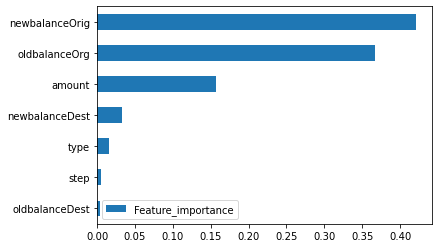

In [109]:
importances = pd.DataFrame(dt_classifier.feature_importances_, X_train.columns, 
                           columns=['Feature_importance'])
importances.sort_values(by = 'Feature_importance').plot.barh()

## XGBoost Classifier

In [133]:
xgb_classifier = XGBClassifier()
xgb_classifier.fit(X_train_over, y_train_over)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [134]:
xgb_y_val_pred = xgb_model.predict(X_val)

#Confusion Matrix
print(confusion_matrix(y_val, xgb_y_val_pred))
#Classification Report
print(classification_report(y_val, xgb_y_val_pred))

[[345271 671467]
 [   141   1141]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270904
           1       0.43      0.99      0.60      1620

    accuracy                           1.00   1272524
   macro avg       0.71      0.99      0.80   1272524
weighted avg       1.00      1.00      1.00   1272524



<AxesSubplot:>

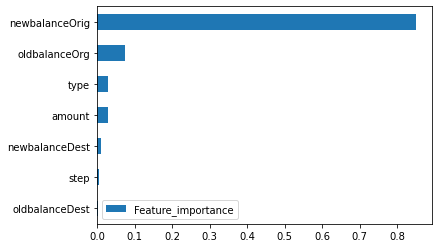

In [135]:
importances = pd.DataFrame(xgb_model.feature_importances_, X_train.columns, 
                           columns=['Feature_importance'])
importances.sort_values(by = 'Feature_importance').plot.barh()

In [116]:
joblib.dump(xgb_classifier, 'xgb_classifier.pkl')

['xgb_classifier.pkl']

## CatBoost Classifier

In [117]:
catboost_classifier = CatBoostClassifier(iterations=200,
                              random_state = 42,
                             learning_rate = 0.02,
                             early_stopping_rounds=20,                             
                             task_type='GPU')

In [129]:
catboost_classifier.fit(X_train_over, y_train_over)

0:	learn: 0.6336313	total: 66.9ms	remaining: 13.3s
1:	learn: 0.5801439	total: 134ms	remaining: 13.2s
2:	learn: 0.5322407	total: 199ms	remaining: 13.1s
3:	learn: 0.4884235	total: 266ms	remaining: 13s
4:	learn: 0.4516043	total: 327ms	remaining: 12.8s
5:	learn: 0.4188208	total: 390ms	remaining: 12.6s
6:	learn: 0.3877835	total: 452ms	remaining: 12.5s
7:	learn: 0.3591307	total: 518ms	remaining: 12.4s
8:	learn: 0.3336956	total: 584ms	remaining: 12.4s
9:	learn: 0.3108558	total: 650ms	remaining: 12.4s
10:	learn: 0.2907181	total: 713ms	remaining: 12.3s
11:	learn: 0.2758639	total: 774ms	remaining: 12.1s
12:	learn: 0.2600305	total: 837ms	remaining: 12s
13:	learn: 0.2458114	total: 898ms	remaining: 11.9s
14:	learn: 0.2322760	total: 961ms	remaining: 11.9s
15:	learn: 0.2216944	total: 1.02s	remaining: 11.8s
16:	learn: 0.2110050	total: 1.09s	remaining: 11.7s
17:	learn: 0.2021974	total: 1.16s	remaining: 11.7s
18:	learn: 0.1939368	total: 1.22s	remaining: 11.7s
19:	learn: 0.1864544	total: 1.29s	remaining:

164:	learn: 0.0366799	total: 10.7s	remaining: 2.27s
165:	learn: 0.0365054	total: 10.8s	remaining: 2.21s
166:	learn: 0.0364223	total: 10.8s	remaining: 2.14s
167:	learn: 0.0363396	total: 10.9s	remaining: 2.08s
168:	learn: 0.0362396	total: 11s	remaining: 2.01s
169:	learn: 0.0360779	total: 11s	remaining: 1.95s
170:	learn: 0.0359848	total: 11.1s	remaining: 1.88s
171:	learn: 0.0359099	total: 11.2s	remaining: 1.82s
172:	learn: 0.0356932	total: 11.2s	remaining: 1.75s
173:	learn: 0.0354361	total: 11.3s	remaining: 1.69s
174:	learn: 0.0353232	total: 11.3s	remaining: 1.62s
175:	learn: 0.0351773	total: 11.4s	remaining: 1.56s
176:	learn: 0.0351078	total: 11.5s	remaining: 1.49s
177:	learn: 0.0350374	total: 11.5s	remaining: 1.43s
178:	learn: 0.0349628	total: 11.6s	remaining: 1.36s
179:	learn: 0.0348649	total: 11.7s	remaining: 1.3s
180:	learn: 0.0347983	total: 11.7s	remaining: 1.23s
181:	learn: 0.0345978	total: 11.8s	remaining: 1.17s
182:	learn: 0.0345322	total: 11.9s	remaining: 1.1s
183:	learn: 0.0344

In [130]:
catboost_y_val_pred = catboost_classifier.predict(X_val)

#Confusion Matrix
print(confusion_matrix(y_val, catboost_y_val_pred))

#Classification Report
print(classification_report(y_val, catboost_y_val_pred))

[[1001217   15521]
 [     11    1271]]
              precision    recall  f1-score   support

           0       1.00      0.98      0.99   1016738
           1       0.08      0.99      0.14      1282

    accuracy                           0.98   1018020
   macro avg       0.54      0.99      0.57   1018020
weighted avg       1.00      0.98      0.99   1018020



<AxesSubplot:>

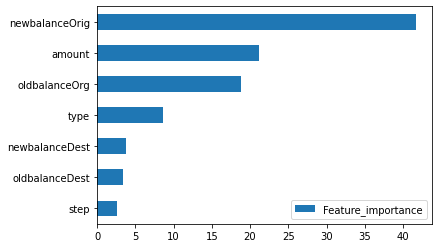

In [120]:
importances = pd.DataFrame(catboost.feature_importances_, X_train.columns, 
                           columns=['Feature_importance'])
importances.sort_values(by = 'Feature_importance').plot.barh()

In [122]:
joblib.dump(catboost_classifier, 'catboost_classifier.pkl')

['catboost_classifier.pkl']

## Test Set 결과

In [136]:
dt_y_test_pred = dt_classifier.predict(X_test)
xgb_y_test_pred = xgb_classifier.predict(X_test)
catboost_y_test_pred = catboost_classifier.predict(X_test)

In [138]:
print("Decision Tree Model")
print(classification_report(y_test, dt_y_test_pred))
print("XGBoost Model")
print(classification_report(y_test, xgb_y_test_pred))
print("CatBoost Model")
print(classification_report(y_test, catboost_y_test_pred))

Decision Tree Model
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270904
           1       0.71      0.96      0.81      1620

    accuracy                           1.00   1272524
   macro avg       0.85      0.98      0.91   1272524
weighted avg       1.00      1.00      1.00   1272524

XGBoost Model
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270904
           1       0.43      0.99      0.60      1620

    accuracy                           1.00   1272524
   macro avg       0.71      0.99      0.80   1272524
weighted avg       1.00      1.00      1.00   1272524

CatBoost Model
              precision    recall  f1-score   support

           0       1.00      0.98      0.99   1270904
           1       0.08      1.00      0.14      1620

    accuracy                           0.98   1272524
   macro avg       0.54      0.99      0.57   1272524
weighted avg       1.00  

총 3가지 모델을 살펴보았을 때 recall 값에 중요도를 놓고 본다면 XGB, CatBoost 모델이 좋은 성능을 보이고 있습니다. 이는 위에서 언급했듯이 실제 사기인 것 중에 올바르게 사기라고 맞춘 것의 비율이기 때문에 중요한 지표는 맞습니다.
그러나, 결제, 이체 과정에서 정상적인 결과를 사기라고 예측한다면 그것 또한 문제가 될 수 있기 때문에 전반적인 성능이 높은 DecisionTree 모델을 이용해 예측을 진행하는 것이 좋다고 생각합니다.

지금까지의 결과를 종합하면 결제, 이체 과정에서 발생하는 사기는 이체, 그리고 cash-out 출금 과정에서 일어나는 것을 알 수 있습니다. 
이 과정에 좀 더 집중하여 사기를 탐지한다면 좀 더 안정적인 뱅킹 시스템을 구축할 수 있을 것이라고 생각합니다.